# March Machine Learning Mania
In this notebook, we perform __EDA__ on the provided data via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview).

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# global random seed
SEED = 9

## Load Data

In [2]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'



# reg season results
regresults = pd.concat([pd.read_csv(mroot + 'MRegularSeasonCompactResults.csv'), pd.read_csv(wroot + 'WRegularSeasonCompactResults.csv')], ignore_index=True)

# historical tourney results
results = pd.concat([pd.read_csv(mroot + 'MNCAATourneyCompactResults.csv'), pd.read_csv(wroot + 'WNCAATourneyCompactResults.csv')], ignore_index=True)

# historical seeds
seeds =  pd.concat([pd.read_csv(mroot + 'MNCAATourneySeeds.csv'), pd.read_csv(wroot + 'WNCAATourneySeeds.csv')], ignore_index=True)

# tourney slots
mslots = pd.read_csv(mroot + 'MNCAATourneySlots.csv')
wslots = pd.read_csv(wroot + 'WNCAATourneySlots.csv')

# team names
teams = pd.concat([pd.read_csv(mroot + 'MTeams.csv'), pd.read_csv(wroot + 'WTeams.csv')], ignore_index=True)



# create a map for team names
team_map = teams.set_index('TeamID')['TeamName']

## Feature Creation

We can simply generalize a lot from the seed of the team (and their opponent). The seed bakes in the performance of the team that year, as well as recent performance and key injuries. Even though the primary focus of seeding is on team performance, geography is also considered (to minimize travel for team/fans). This means that seeding may not be the perfect metric to use.

---
---

Features that may help predict a team's tourney performance (__Pre-bracket__):

__Features__ = features of that team's season, __Labels__ = Num wins in NCAA tourney, OR Binary W/L or score diff
- Wins
- Losses
- Win %
- Home/Road Win %
- Wins/Losses recently (say a month) before tourney
- Performance in conference tourney
- Performance in tourney prior year
- Avg/std pts
- Avg/std of opponent pts
- Avg/std pt differential
- Detailed stats
- Num championships in the past
- Play-in team?
- Longest win-streak in season

---

Features after 1st round is complete (__Intra-bracket__):

__Features__ = features of team's bracket stats so far
- Avg/std pts
- Avg/std of opponent pts
- Avg/std pt differential
- Detailed stats
- Coming off upset?

In [219]:
# compute score differential
regresults['ScoreDiff'] = regresults['WScore'] - regresults['LScore']

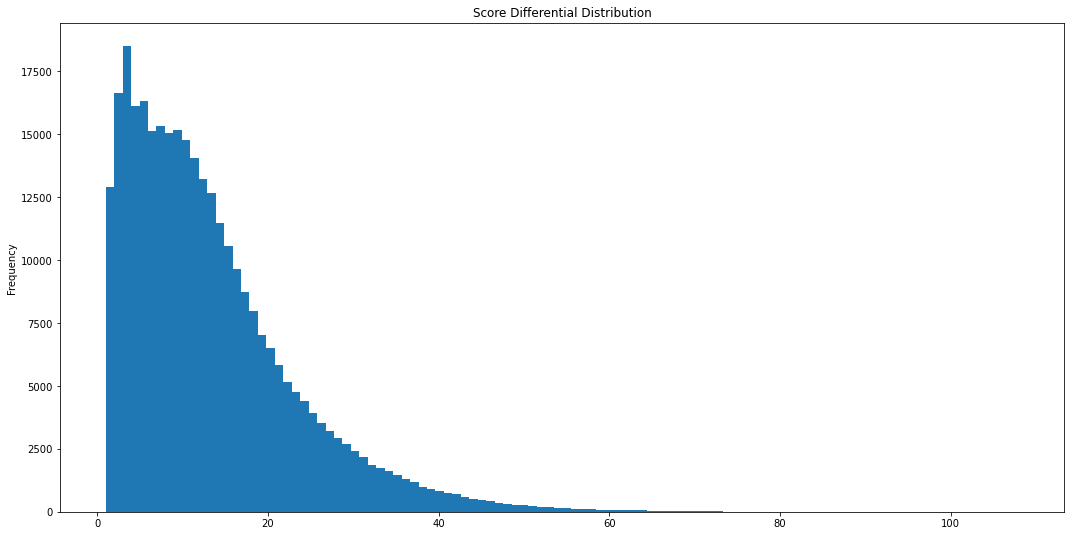

In [220]:
# look at dist of score differential in reg season games
regresults['ScoreDiff'].plot(kind='hist', bins=108, figsize=(18, 9), title='Score Differential Distribution');

In [221]:
# some groups we will be using
win_group = regresults.groupby(['Season', 'WTeamID'])
lose_group = regresults.groupby(['Season', 'LTeamID'])

In [222]:
# get wins and losses for every team in every season
num_wins = win_group.count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'num_wins', 'WTeamID': 'TeamID'})
num_losses = lose_group.count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'num_losses', 'LTeamID': 'TeamID'})

# merge wins and losses, fill nulls, cast to int, drop tables
win_loss = num_wins.merge(num_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
win_loss = win_loss.astype({'num_wins': int, 'num_losses': int})
del num_wins, num_losses

# add games played
win_loss['num_games'] = win_loss['num_wins'] + win_loss['num_losses']

# add ratio
win_loss['win_ratio'] = win_loss['num_wins'] / (win_loss['num_wins'] + win_loss['num_losses'])

# check
print(win_loss.shape)
win_loss.head()

(22150, 6)


,Season,TeamID,num_wins,num_losses,num_games,win_ratio
0,1985,1102,5,19,24,0.208333
1,1985,1103,9,14,23,0.391304
2,1985,1104,21,9,30,0.700000
3,1985,1106,10,14,24,0.416667
4,1985,1108,19,6,25,0.760000


In [223]:
# 20 undefeated seasons
win_loss.loc[win_loss['num_losses'] == 0].shape

(20, 6)

In [224]:
# 48 winless seasons
win_loss.loc[win_loss['num_wins'] == 0].shape

(48, 6)

In [225]:
# get score diff features for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['sum', 'var', 'max']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_win_diff', 'var': 'var_win_diff', 'max': 'max_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['sum', 'var', 'max']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_loss_diff', 'var': 'var_loss_diff', 'max': 'max_loss_diff'})

# get pts for and against each team for wins and losses
pts_for_win = win_group['WScore'].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_pts_for_win', 'mean': 'mean_pts_for_win', 'var': 'var_pts_for_win'})
pts_against_win = win_group['LScore'].agg(['sum', 'mean', 'var']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_pts_against_win', 'mean': 'mean_pts_against_win', 'var': 'var_pts_against_win'})
pts_for_loss = lose_group['LScore'].agg(['sum', 'mean', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_pts_for_loss', 'mean': 'mean_pts_for_loss', 'var': 'var_pts_for_loss'})
pts_against_loss = lose_group['WScore'].agg(['sum', 'mean', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_pts_against_loss', 'mean': 'mean_pts_against_loss', 'var': 'var_pts_against_loss'})

# merge features, fill nulls, typecast, drop tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_for_win, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_against_win, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_for_loss, on=['Season', 'TeamID'], how='outer')
pts = pts.merge(pts_against_loss, on=['Season', 'TeamID'], how='outer')
pts = pts.fillna(0)
pts = pts.astype({'sum_win_diff': int, 'sum_loss_diff': int, 'max_win_diff': int, 'max_loss_diff': int, 'sum_pts_for_win': int, 'sum_pts_against_win': int, 'sum_pts_for_loss': int, 
                  'sum_pts_against_loss': int})
del win_gaps, loss_gaps, pts_for_win, pts_against_win, pts_for_loss, pts_against_loss

# create 'merged' df by merging pts with win_loss
merged = pts.merge(win_loss, on=['Season', 'TeamID'], how='outer')
del win_loss, pts

# check
merged.head()

,Season,TeamID,sum_win_diff,var_win_diff,max_win_diff,sum_loss_diff,var_loss_diff,max_loss_diff,sum_pts_for_win,mean_pts_for_win,var_pts_for_win,sum_pts_against_win,mean_pts_against_win,var_pts_against_win,sum_pts_for_loss,mean_pts_for_loss,var_pts_for_loss,sum_pts_against_loss,mean_pts_against_loss,var_pts_against_loss,num_wins,num_losses,num_games,win_ratio
0,1985,1102,50,124.000000,29,189,91.497076,41,355,71.000000,224.000000,305,61.000000,144.500000,1159,61.000000,55.111111,1348,70.947368,76.941520,5,19,24,0.208333
1,1985,1103,68,37.277778,16,138,42.131868,22,632,70.222222,114.444444,564,62.666667,98.500000,772,55.142857,43.208791,910,65.000000,66.461538,9,14,23,0.391304
2,1985,1104,277,66.061905,25,43,11.694444,12,1514,72.095238,185.090476,1237,58.904762,130.290476,541,60.111111,120.611111,584,64.888889,177.861111,21,9,30,0.700000
3,1985,1106,95,87.388889,28,186,123.604396,35,751,75.100000,60.322222,656,65.600000,61.822222,968,69.142857,187.208791,1154,82.428571,196.571429,10,14,24,0.416667
4,1985,1108,263,119.251462,35,64,21.866667,15,1631,85.842105,222.362573,1368,72.000000,79.333333,444,74.000000,22.800000,508,84.666667,19.066667,19,6,25,0.760000


In [226]:
# calculate mean pts for/against per game
merged['mean_ppg'] = (merged['sum_pts_for_win'] + merged['sum_pts_for_loss']) / merged['num_games']
merged['mean_papg'] = (merged['sum_pts_against_win'] + merged['sum_pts_against_loss']) / merged['num_games']

# calculate std pts for/against per game
merged['std_ppg'] = np.sqrt(((merged['var_pts_for_win'] * merged['num_wins']) + (merged['var_pts_for_loss'] * merged['num_losses'])) / merged['num_games'])
merged['std_papg'] = np.sqrt(((merged['var_pts_against_win'] * merged['num_wins']) + (merged['var_pts_against_loss'] * merged['num_losses'])) / merged['num_games'])

# calculate mean score diff per game
merged['mean_diff'] = merged['mean_ppg'] - merged['mean_papg']

# calculate std score diff per game
merged['std_diff'] = np.sqrt(((merged['var_win_diff'] * merged['num_wins']) + (merged['var_loss_diff'] * merged['num_losses']) + \
                            (merged['num_wins'] * (((merged['sum_win_diff'] / merged['num_wins']) - merged['mean_diff'])**2)) + \
                            (merged['num_losses'] * (((merged['sum_loss_diff'] / merged['num_losses']) - merged['mean_diff'])**2))) / \
                            merged['num_games'])

# drop old cols
merged = merged.drop(columns=['sum_win_diff', 'sum_loss_diff', 'sum_pts_for_win', 'sum_pts_against_win', 'sum_pts_for_loss', 'sum_pts_against_loss', 'var_win_diff', 'var_loss_diff', 
                              'var_pts_for_win', 'var_pts_against_win', 'var_pts_for_loss', 'var_pts_against_loss', 'mean_pts_for_win', 'mean_pts_against_win', 'mean_pts_for_loss', 
                              'mean_pts_against_loss', 'num_wins', 'num_losses'])

# check
merged.head()

,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff
0,1985,1102,29,41,24,0.208333,63.083333,68.875000,9.502436,9.540241,-5.791667,18.609983
1,1985,1103,16,22,23,0.391304,61.043478,64.086957,8.431110,8.888100,-3.043478,13.619625
2,1985,1104,25,12,30,0.700000,68.500000,60.700000,12.874264,12.023380,7.800000,8.534159
3,1985,1106,28,35,24,0.416667,71.625000,75.416667,11.590487,11.850145,-3.791667,18.768271
4,1985,1108,35,15,25,0.760000,83.000000,75.040000,13.208617,8.054150,7.960000,11.132508


In [227]:
# get H/A/N wins for each team
home_wins = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'home_wins', 'WTeamID': 'TeamID'})
away_wins = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'away_wins', 'WTeamID': 'TeamID'})
neutral_wins = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'neutral_wins', 'WTeamID': 'TeamID'})

# get H/A/N losses for each team
home_losses = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'home_losses', 'LTeamID': 'TeamID'})
away_losses = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'away_losses', 'LTeamID': 'TeamID'})
neutral_losses = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'neutral_losses', 'LTeamID': 'TeamID'})

# combine, fill nulls, typecast, drop tables
merged = merged.merge(home_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(home_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'home_wins': int, 'away_wins': int, 'neutral_wins': int, 'home_losses': int, 'away_losses': int, 'neutral_losses': int})
del home_wins, away_wins, neutral_wins, home_losses, away_losses, neutral_losses

# calculate win ratios for H/A/N games
merged['home_win_ratio'] = merged['home_wins'] / (merged['home_wins'] + merged['home_losses'])
merged['away_win_ratio'] = merged['away_wins'] / (merged['away_wins'] + merged['away_losses'])
merged['neutral_win_ratio'] = merged['neutral_wins'] / (merged['neutral_wins'] + merged['neutral_losses'])
merged = merged.fillna(0)

# drop old cols
merged = merged.drop(columns=['home_wins', 'away_wins', 'neutral_wins', 'home_losses', 'away_losses', 'neutral_losses'])

# check
merged.head()

,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio
0,1985,1102,29,41,24,0.208333,63.083333,68.875000,9.502436,9.540241,-5.791667,18.609983,0.200000,0.250000,0.000000
1,1985,1103,16,22,23,0.391304,61.043478,64.086957,8.431110,8.888100,-3.043478,13.619625,0.538462,0.200000,0.000000
2,1985,1104,25,12,30,0.700000,68.500000,60.700000,12.874264,12.023380,7.800000,8.534159,0.937500,0.454545,0.333333
3,1985,1106,28,35,24,0.416667,71.625000,75.416667,11.590487,11.850145,-3.791667,18.768271,0.888889,0.090909,0.250000
4,1985,1108,35,15,25,0.760000,83.000000,75.040000,13.208617,8.054150,7.960000,11.132508,0.888889,0.666667,0.750000


In [228]:
# get all rows for each team where they won/lost by 3 points or less
close_wins = regresults.loc[regresults['ScoreDiff'] <= 3].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: '1_pos_wins', 'WTeamID': 'TeamID'})
close_losses = regresults.loc[regresults['ScoreDiff'] >= 3].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: '1_pos_losses', 'LTeamID': 'TeamID'})

# get num of games where NumOT > 0
ot_wins = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'ot_wins', 'WTeamID': 'TeamID'})
ot_losses = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'ot_losses', 'LTeamID': 'TeamID'})

# merge, fill nulls, typecast, drop tables
merged = merged.merge(close_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(close_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'1_pos_wins': int, '1_pos_losses': int, 'ot_wins': int, 'ot_losses': int})
del close_wins, close_losses, ot_wins, ot_losses

# add missing indicator columns
merged['1_pos_win_missing'] = np.where(merged['1_pos_wins'] == 0, 1, 0)
merged['1_pos_loss_missing'] = np.where(merged['1_pos_losses'] == 0, 1, 0)
merged['ot_win_missing'] = np.where(merged['ot_wins'] == 0, 1, 0)
merged['ot_loss_missing'] = np.where(merged['ot_losses'] == 0, 1, 0)

# calculate close and ot ratios
merged['1_pos_game_ratio'] = (merged['1_pos_wins'] + merged['1_pos_losses']) / merged['num_games']
merged['1_pos_win_ratio'] = merged['1_pos_wins'] / (merged['1_pos_wins'] + merged['1_pos_losses'])
merged['ot_ratio'] = (merged['ot_wins'] + merged['ot_losses']) / merged['num_games']
merged['ot_win_ratio'] = merged['ot_wins'] / (merged['ot_wins'] + merged['ot_losses'])

# fill nulls for teams that never played in close or ot games
merged = merged.fillna(0)

# drop old cols
merged = merged.drop(columns=['1_pos_wins', '1_pos_losses', 'ot_wins', 'ot_losses'])

# check
merged.head()

,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_win_missing,1_pos_loss_missing,ot_win_missing,ot_loss_missing,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio
0,1985,1102,29,41,24,0.208333,63.083333,68.875000,9.502436,9.540241,-5.791667,18.609983,0.200000,0.250000,0.000000,0,0,1,1,0.708333,0.117647,0.000000,0.0
1,1985,1103,16,22,23,0.391304,61.043478,64.086957,8.431110,8.888100,-3.043478,13.619625,0.538462,0.200000,0.000000,0,0,1,1,0.652174,0.266667,0.000000,0.0
2,1985,1104,25,12,30,0.700000,68.500000,60.700000,12.874264,12.023380,7.800000,8.534159,0.937500,0.454545,0.333333,0,0,1,0,0.366667,0.363636,0.033333,0.0
3,1985,1106,28,35,24,0.416667,71.625000,75.416667,11.590487,11.850145,-3.791667,18.768271,0.888889,0.090909,0.250000,0,0,1,1,0.625000,0.266667,0.000000,0.0
4,1985,1108,35,15,25,0.760000,83.000000,75.040000,13.208617,8.054150,7.960000,11.132508,0.888889,0.666667,0.750000,0,0,1,1,0.440000,0.454545,0.000000,0.0


In [229]:
# num of final reg season games to aggregate
RECENT_GAMES = 6

# get last RECENT_GAMES wins and last RECENT_GAMES losses of each team (to assess recent form going into tourney)
recent_wins = win_group.tail(RECENT_GAMES).reset_index(drop=True)
recent_losses = lose_group.tail(RECENT_GAMES).reset_index(drop=True)

# add TeamID col to identify thw rows pertaining to each team
recent_wins['TeamID'] = recent_wins['WTeamID']
recent_losses['TeamID'] = recent_losses['LTeamID']

# get last RECENT_GAMES games
combined = pd.concat([recent_wins, recent_losses], ignore_index=True).sort_values(by=['Season', 'TeamID', 'DayNum']).reset_index(drop=True)
last_recent_games = combined.groupby(['Season', 'TeamID']).tail(RECENT_GAMES).reset_index(drop=True)
del combined, recent_wins, recent_losses

# check
last_recent_games.head(6)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreDiff,TeamID
0,1985,115,1102,52,1461,49,A,0,3,1102
1,1985,117,1102,58,1218,54,H,0,4,1102
2,1985,120,1161,65,1102,63,A,0,2,1102
3,1985,122,1428,60,1102,59,A,0,1,1102
4,1985,126,1102,82,1140,79,A,0,3,1102
5,1985,127,1428,66,1102,64,H,0,2,1102


In [230]:
# look at teams who don't have a final RECEENT_GAMES games
last_recent_games.groupby(['Season', 'TeamID']).size().reset_index().rename(columns={0: 'num_games'}).sort_values(by='num_games', ascending=True).head(10)

,Season,TeamID,num_games
19987,2021,3469,2
19887,2021,3363,4
19714,2021,3181,4
19410,2021,1224,4
19684,2021,3145,5
19960,2021,3438,5
0,1985,1102,6
14765,2014,3126,6
14764,2014,3125,6
14763,2014,3124,6


- There were 6 teams in 2021 who did not even have 6 games played (the current value for RECENT_GAMES). I will need to take this into account when calculating win ratio.

In [231]:
# some groups we use
recent_win_group = last_recent_games.loc[last_recent_games['WTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])
recent_loss_group = last_recent_games.loc[last_recent_games['LTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])

# merge wins and losses for each team -> outer merge because some teams have no wins or losses in the last RECENT_GAMES games
recent = pd.merge(recent_win_group.size().reset_index().rename(columns={0: 'recent_wins', 'WTeamID': 'TeamID'}), \
                  recent_loss_group.size().reset_index().rename(columns={0: 'recent_losses', 'LTeamID': 'TeamID'}), on=['Season', 'TeamID'], how='outer').fillna(0)

# num games played by the team
num_games = (recent['recent_wins'] + recent['recent_losses'])

# calculate win ratio for last RECENT_GAMES games
recent['recent_win_ratio'] = recent['recent_wins'] / num_games

# calculate sum/var of pts for and against in wins and losses
recent_pts_for_win = recent_win_group['WScore'].agg(['sum', 'var']).reset_index().rename(columns={'sum': 'recent_pts_for_win', 'var': 'recent_var_pts_for_win', 'WTeamID': 'TeamID'})
recent_pts_for_loss = recent_loss_group['LScore'].agg(['sum', 'var']).reset_index().rename(columns={'sum': 'recent_pts_for_loss', 'var': 'recent_var_pts_for_loss', 'LTeamID': 'TeamID'})
recent_pts_against_win = recent_win_group['LScore'].agg(['sum', 'var']).reset_index() \
    .rename(columns={'sum': 'recent_pts_against_win', 'var': 'recent_var_pts_against_win', 'WTeamID': 'TeamID'})
recent_pts_against_loss = recent_loss_group['WScore'].agg(['sum', 'var']).reset_index() \
    .rename(columns={'sum': 'recent_pts_against_loss', 'var': 'recent_var_pts_against_loss', 'LTeamID': 'TeamID'})

# var of score differential for wins and losses
score_diff_win = recent_win_group.apply(lambda df: (df['WScore'] - df['LScore']).var()).reset_index().rename(columns={0: 'var_score_diff_win', 'WTeamID': 'TeamID'})
score_diff_loss = recent_loss_group.apply(lambda df: (df['LScore'] - df['WScore']).var()).reset_index().rename(columns={0: 'var_score_diff_loss', 'LTeamID': 'TeamID'})

# merge, fill nulls, drop tables
recent = recent.merge(recent_pts_for_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_for_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_against_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(recent_pts_against_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(score_diff_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(score_diff_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.fillna(0)
del recent_pts_for_win, recent_pts_for_loss, recent_pts_against_win, recent_pts_against_loss, score_diff_win, score_diff_loss, recent_win_group, recent_loss_group, last_recent_games

# calculate mean pts for and against
recent['recent_mean_pts_for'] = (recent['recent_pts_for_win'] + recent['recent_pts_for_loss']) / num_games
recent['recent_mean_pts_against'] = (recent['recent_pts_against_win'] + recent['recent_pts_against_loss']) / num_games
recent['recent_mean_score_diff'] = recent['recent_mean_pts_for'] - recent['recent_mean_pts_against']

# rough approximation that assumes equal variance from wins and losses
recent['recent_std_pts_for'] = np.sqrt(((recent['recent_var_pts_for_win'] * recent['recent_wins']) + (recent['recent_var_pts_for_loss'] * recent['recent_losses'])) / num_games)
recent['recent_std_pts_against'] = np.sqrt(((recent['recent_var_pts_against_win'] * recent['recent_wins']) + (recent['recent_var_pts_against_loss'] * recent['recent_losses'])) / num_games)
recent['recent_std_score_diff'] = np.sqrt(((recent['var_score_diff_win'] * recent['recent_wins']) + (recent['var_score_diff_loss'] * recent['recent_losses'])) / num_games)

# drop old cols
recent = recent.drop(columns=['recent_wins', 'recent_losses', 'recent_pts_for_win', 'recent_pts_for_loss', 'recent_pts_against_win', 'recent_pts_against_loss', 'recent_var_pts_for_win', 
                              'recent_var_pts_for_loss', 'recent_var_pts_against_win', 'recent_var_pts_against_loss', 'var_score_diff_win', 'var_score_diff_loss'])

# check
recent.head()

,Season,TeamID,recent_win_ratio,recent_mean_pts_for,recent_mean_pts_against,recent_mean_score_diff,recent_std_pts_for,recent_std_pts_against,recent_std_score_diff
0,1985,1102,0.500000,63.000000,62.166667,0.833333,11.379807,11.590226,0.577350
1,1985,1103,0.500000,63.166667,65.500000,-2.333333,10.230673,5.916080,8.784456
2,1985,1104,0.833333,64.666667,51.333333,13.333333,15.129992,11.708259,5.492419
3,1985,1106,0.500000,78.500000,82.166667,-3.666667,4.795832,14.005951,11.409061
4,1985,1108,0.833333,74.500000,72.166667,2.333333,17.554676,12.951834,6.271629


In [232]:
# merge 2 final tables
merged = merged.merge(recent, on=['Season', 'TeamID'], how='outer').sort_values(['Season', 'TeamID'])
del recent

# check
print(merged.shape)
merged.head()

(22150, 30)


,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_win_missing,1_pos_loss_missing,ot_win_missing,ot_loss_missing,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio,recent_win_ratio,recent_mean_pts_for,recent_mean_pts_against,recent_mean_score_diff,recent_std_pts_for,recent_std_pts_against,recent_std_score_diff
0,1985,1102,29,41,24,0.208333,63.083333,68.875000,9.502436,9.540241,-5.791667,18.609983,0.200000,0.250000,0.000000,0,0,1,1,0.708333,0.117647,0.000000,0.0,0.500000,63.000000,62.166667,0.833333,11.379807,11.590226,0.577350
1,1985,1103,16,22,23,0.391304,61.043478,64.086957,8.431110,8.888100,-3.043478,13.619625,0.538462,0.200000,0.000000,0,0,1,1,0.652174,0.266667,0.000000,0.0,0.500000,63.166667,65.500000,-2.333333,10.230673,5.916080,8.784456
2,1985,1104,25,12,30,0.700000,68.500000,60.700000,12.874264,12.023380,7.800000,8.534159,0.937500,0.454545,0.333333,0,0,1,0,0.366667,0.363636,0.033333,0.0,0.833333,64.666667,51.333333,13.333333,15.129992,11.708259,5.492419
3,1985,1106,28,35,24,0.416667,71.625000,75.416667,11.590487,11.850145,-3.791667,18.768271,0.888889,0.090909,0.250000,0,0,1,1,0.625000,0.266667,0.000000,0.0,0.500000,78.500000,82.166667,-3.666667,4.795832,14.005951,11.409061
4,1985,1108,35,15,25,0.760000,83.000000,75.040000,13.208617,8.054150,7.960000,11.132508,0.888889,0.666667,0.750000,0,0,1,1,0.440000,0.454545,0.000000,0.0,0.833333,74.500000,72.166667,2.333333,17.554676,12.951834,6.271629


In __merged__, each row is a single NCAA team's entire season with aggregated data from their wins and losses. We have access to over 22k NCAA basketball seasons. Kepp in mind, only 64 teams make the tournament each year, so most of the rows in this dataframe will not be part of the follwing merge.

In [235]:
# merge results with seeds
df = pd.merge(results, seeds, how='left', left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'WSeed'}).drop(columns='TeamID')
df = pd.merge(df, seeds, how='left', left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'LSeed'}).drop(columns='TeamID')
del results, seeds

# seperate region and seed
df['WFullSeed'] = df['WSeed']
df['LFullSeed'] = df['LSeed']
df['WRegion'] = df['WSeed'].apply(lambda x: x[0])
df['LRegion'] = df['LSeed'].apply(lambda x: x[0])
df['WSeed'] = df['WSeed'].apply(lambda x: x[1:])
df['LSeed'] = df['LSeed'].apply(lambda x: x[1:])

# add play-in col for winning and losing teams
df['WPlayIn'] = df['WSeed'].apply(lambda x: 1 if len(x) > 2 else 0)
df['LPlayIn'] = df['LSeed'].apply(lambda x: 1 if len(x) > 2 else 0)

# drop letter and convert to int
df['WSeed'] = df['WSeed'].apply(lambda x: int(x[:2]))
df['LSeed'] = df['LSeed'].apply(lambda x: int(x[:2]))

# check
print(df.shape)
df.head()

(4034, 16)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WFullSeed,LFullSeed,WRegion,LRegion,WPlayIn,LPlayIn
0,1985,136,1116,63,1234,54,N,0,9,8,X09,X08,X,X,0,0
1,1985,136,1120,59,1345,58,N,0,11,6,Z11,Z06,Z,Z,0,0
2,1985,136,1207,68,1250,43,N,0,1,16,W01,W16,W,W,0,0
3,1985,136,1229,58,1425,55,N,0,9,8,Y09,Y08,Y,Y,0,0
4,1985,136,1242,49,1325,38,N,0,3,14,Z03,Z14,Z,Z,0,0


In __df__, each row is a NCAA Tournament game. We have access to over 4k games, which will effectively act as our labels.

In [236]:
# merge df with merged for winning and losing teams
df = pd.merge(df, merged, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'W' + x for x in merged.columns[2:]})
df = pd.merge(df, merged, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'L' + x for x in merged.columns[2:]})
del merged

# check
print(df.shape)
df.head()

(4034, 72)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WFullSeed,LFullSeed,WRegion,LRegion,WPlayIn,LPlayIn,Wmax_win_diff,Wmax_loss_diff,Wnum_games,Wwin_ratio,Wmean_ppg,Wmean_papg,Wstd_ppg,Wstd_papg,Wmean_diff,Wstd_diff,Whome_win_ratio,Waway_win_ratio,Wneutral_win_ratio,W1_pos_win_missing,W1_pos_loss_missing,Wot_win_missing,Wot_loss_missing,W1_pos_game_ratio,W1_pos_win_ratio,Wot_ratio,Wot_win_ratio,Wrecent_win_ratio,Wrecent_mean_pts_for,Wrecent_mean_pts_against,Wrecent_mean_score_diff,Wrecent_std_pts_for,Wrecent_std_pts_against,Wrecent_std_score_diff,Lmax_win_diff,Lmax_loss_diff,Lnum_games,Lwin_ratio,Lmean_ppg,Lmean_papg,Lstd_ppg,Lstd_papg,Lmean_diff,Lstd_diff,Lhome_win_ratio,Laway_win_ratio,Lneutral_win_ratio,L1_pos_win_missing,L1_pos_loss_missing,Lot_win_missing,Lot_loss_missing,L1_pos_game_ratio,L1_pos_win_ratio,Lot_ratio,Lot_win_ratio,Lrecent_win_ratio,Lrecent_mean_pts_for,Lrecent_mean_pts_against,Lrecent_mean_score_diff,Lrecent_std_pts_for,Lrecent_std_pts_against,Lrecent_std_score_diff
0,1985,136,1116,63,1234,54,N,0,9,8,X09,X08,X,X,0,0,35,20,33,0.636364,65.333333,61.696970,11.332454,9.055902,3.636364,9.620253,0.909091,0.333333,0.700000,0,0,1,1,0.363636,0.250000,0.000000,0.0,0.666667,74.166667,61.500000,12.666667,15.382169,8.624899,8.286535,49,20,30,0.666667,69.733333,59.266667,12.375335,11.243712,10.466667,13.416676,0.833333,0.333333,0.666667,0,0,1,1,0.233333,0.142857,0.000000,0.0,0.333333,62.500000,63.833333,-1.333333,7.207249,15.625833,9.061518
1,1985,136,1120,59,1345,58,N,0,11,6,Z11,Z06,Z,Z,0,0,42,19,29,0.620690,70.344828,66.655172,13.523340,11.519276,3.689655,12.768266,0.666667,0.454545,0.833333,0,0,0,0,0.482759,0.428571,0.068966,0.5,0.833333,63.166667,57.000000,6.166667,14.250731,6.689544,9.278110,31,43,25,0.680000,69.120000,65.320000,10.537755,8.837016,3.800000,13.685843,0.714286,0.600000,1.000000,0,0,1,1,0.400000,0.200000,0.000000,0.0,0.666667,66.333333,68.833333,-2.500000,12.270108,4.778424,11.172884
2,1985,136,1207,68,1250,43,N,0,1,16,W01,W16,W,W,0,0,41,2,27,0.925926,75.740741,60.074074,11.475417,10.523929,15.666667,10.490513,0.923077,0.857143,1.000000,0,1,1,1,0.074074,1.000000,0.000000,0.0,1.000000,83.666667,64.333333,19.333333,10.366613,10.726913,8.594572,18,31,29,0.379310,65.758621,70.206897,8.131251,8.504503,-4.448276,16.284512,0.333333,0.363636,0.500000,0,0,0,1,0.724138,0.238095,0.034483,1.0,0.833333,69.500000,70.000000,-0.500000,7.593857,7.071068,1.500000
3,1985,136,1229,58,1425,55,N,0,9,8,Y09,Y08,Y,Y,0,0,31,13,27,0.740741,71.592593,65.629630,10.506689,10.519915,5.962963,8.956982,0.785714,0.600000,1.000000,0,0,1,1,0.370370,0.400000,0.000000,0.0,0.666667,72.000000,64.833333,7.166667,9.006171,6.940221,8.363280,33,21,28,0.678571,68.392857,64.607143,9.272442,8.751871,3.785714,9.777817,0.642857,0.727273,0.666667,0,0,1,1,0.428571,0.500000,0.000000,0.0,0.500000,68.833333,68.166667,0.666667,6.879922,13.083068,11.561430
4,1985,136,1242,49,1325,38,N,0,3,14,Z03,Z14,Z,Z,0,0,27,19,30,0.766667,76.033333,70.400000,10.420842,11.206870,5.633333,8.081707,1.000000,0.600000,0.500000,0,0,1,1,0.300000,0.333333,0.000000,0.0,0.833333,76.833333,72.166667,4.666667,7.461010,5.228129,5.416026,23,17,27,0.740741,67.555556,63.000000,9.638866,8.801914,4.555556,7.092059,1.000000,0.583333,0.600000,0,0,1,1,0.333333,0.333333,0.000000,0.0,0.833333,68.333333,58.166667,10.166667,7.455423,4.941322,7.762087


In [237]:
# look at game locations (with respect to winning team)
df['WLoc'].value_counts()

WLoc
N    3279
H     613
A     142
Name: count, dtype: int64

Most games are played at a neutral site, however the winning team does play at home much more often than the losing team.

In [238]:
# create LLoc col
df['LLoc'] = df['WLoc'].apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')

# check
df['LLoc'].value_counts()

LLoc
N    3279
A     613
H     142
Name: count, dtype: int64

In [239]:
# women's game locations
df[df['WTeamID'] >= 3000]['WLoc'].value_counts()

WLoc
N    829
H    612
A    142
Name: count, dtype: int64

#### Rearranging the Data
When we input a new row into our model (for the 2024 bracket), the winner could be the first or the second team in the row that we input into our model. Currently, all rows have the winning team on the left, and this will cause our model to learn this locational information. We need to rearrange the order of winners and losers, to where it is essentially random to prevent the model from learning this.

In [240]:
# rename W, L to A, B
df.columns = [x.replace('W', 'A_', 1) if x[0] == 'W' else x for x in df.columns]
df.columns = [x.replace('L', 'B_', 1) if x[0] == 'L' else x for x in df.columns]

# check
df.head()

,Season,DayNum,A_TeamID,A_Score,B_TeamID,B_Score,A_Loc,NumOT,A_Seed,B_Seed,A_FullSeed,B_FullSeed,A_Region,B_Region,A_PlayIn,B_PlayIn,A_max_win_diff,A_max_loss_diff,A_num_games,A_win_ratio,A_mean_ppg,A_mean_papg,A_std_ppg,A_std_papg,A_mean_diff,A_std_diff,A_home_win_ratio,A_away_win_ratio,A_neutral_win_ratio,A_1_pos_win_missing,A_1_pos_loss_missing,A_ot_win_missing,A_ot_loss_missing,A_1_pos_game_ratio,A_1_pos_win_ratio,A_ot_ratio,A_ot_win_ratio,A_recent_win_ratio,A_recent_mean_pts_for,A_recent_mean_pts_against,A_recent_mean_score_diff,A_recent_std_pts_for,A_recent_std_pts_against,A_recent_std_score_diff,B_max_win_diff,B_max_loss_diff,B_num_games,B_win_ratio,B_mean_ppg,B_mean_papg,B_std_ppg,B_std_papg,B_mean_diff,B_std_diff,B_home_win_ratio,B_away_win_ratio,B_neutral_win_ratio,B_1_pos_win_missing,B_1_pos_loss_missing,B_ot_win_missing,B_ot_loss_missing,B_1_pos_game_ratio,B_1_pos_win_ratio,B_ot_ratio,B_ot_win_ratio,B_recent_win_ratio,B_recent_mean_pts_for,B_recent_mean_pts_against,B_recent_mean_score_diff,B_recent_std_pts_for,B_recent_std_pts_against,B_recent_std_score_diff,B_Loc
0,1985,136,1116,63,1234,54,N,0,9,8,X09,X08,X,X,0,0,35,20,33,0.636364,65.333333,61.696970,11.332454,9.055902,3.636364,9.620253,0.909091,0.333333,0.700000,0,0,1,1,0.363636,0.250000,0.000000,0.0,0.666667,74.166667,61.500000,12.666667,15.382169,8.624899,8.286535,49,20,30,0.666667,69.733333,59.266667,12.375335,11.243712,10.466667,13.416676,0.833333,0.333333,0.666667,0,0,1,1,0.233333,0.142857,0.000000,0.0,0.333333,62.500000,63.833333,-1.333333,7.207249,15.625833,9.061518,N
1,1985,136,1120,59,1345,58,N,0,11,6,Z11,Z06,Z,Z,0,0,42,19,29,0.620690,70.344828,66.655172,13.523340,11.519276,3.689655,12.768266,0.666667,0.454545,0.833333,0,0,0,0,0.482759,0.428571,0.068966,0.5,0.833333,63.166667,57.000000,6.166667,14.250731,6.689544,9.278110,31,43,25,0.680000,69.120000,65.320000,10.537755,8.837016,3.800000,13.685843,0.714286,0.600000,1.000000,0,0,1,1,0.400000,0.200000,0.000000,0.0,0.666667,66.333333,68.833333,-2.500000,12.270108,4.778424,11.172884,N
2,1985,136,1207,68,1250,43,N,0,1,16,W01,W16,W,W,0,0,41,2,27,0.925926,75.740741,60.074074,11.475417,10.523929,15.666667,10.490513,0.923077,0.857143,1.000000,0,1,1,1,0.074074,1.000000,0.000000,0.0,1.000000,83.666667,64.333333,19.333333,10.366613,10.726913,8.594572,18,31,29,0.379310,65.758621,70.206897,8.131251,8.504503,-4.448276,16.284512,0.333333,0.363636,0.500000,0,0,0,1,0.724138,0.238095,0.034483,1.0,0.833333,69.500000,70.000000,-0.500000,7.593857,7.071068,1.500000,N
3,1985,136,1229,58,1425,55,N,0,9,8,Y09,Y08,Y,Y,0,0,31,13,27,0.740741,71.592593,65.629630,10.506689,10.519915,5.962963,8.956982,0.785714,0.600000,1.000000,0,0,1,1,0.370370,0.400000,0.000000,0.0,0.666667,72.000000,64.833333,7.166667,9.006171,6.940221,8.363280,33,21,28,0.678571,68.392857,64.607143,9.272442,8.751871,3.785714,9.777817,0.642857,0.727273,0.666667,0,0,1,1,0.428571,0.500000,0.000000,0.0,0.500000,68.833333,68.166667,0.666667,6.879922,13.083068,11.561430,N
4,1985,136,1242,49,1325,38,N,0,3,14,Z03,Z14,Z,Z,0,0,27,19,30,0.766667,76.033333,70.400000,10.420842,11.206870,5.633333,8.081707,1.000000,0.600000,0.500000,0,0,1,1,0.300000,0.333333,0.000000,0.0,0.833333,76.833333,72.166667,4.666667,7.461010,5.228129,5.416026,23,17,27,0.740741,67.555556,63.000000,9.638866,8.801914,4.555556,7.092059,1.000000,0.583333,0.600000,0,0,1,1,0.333333,0.333333,0.000000,0.0,0.833333,68.333333,58.166667,10.166667,7.455423,4.941322,7.762087,N


In [241]:
# choose (half) random rows to flip
np.random.seed(SEED)
flip = np.random.choice(df.index, int(df.shape[0] / 2), replace=False)

# flip A, B cols
for col in df.columns:
    if col[0] == 'A':
        df.loc[flip, col], df.loc[flip, col.replace('A_', 'B_')] = df.loc[flip, col.replace('A_', 'B_')].values, df.loc[flip, col].values

# rearrange cols
df = df.reindex(sorted(df.columns), axis=1)

# check
df.head()

,A_1_pos_game_ratio,A_1_pos_loss_missing,A_1_pos_win_missing,A_1_pos_win_ratio,A_FullSeed,A_Loc,A_PlayIn,A_Region,A_Score,A_Seed,A_TeamID,A_away_win_ratio,A_home_win_ratio,A_max_loss_diff,A_max_win_diff,A_mean_diff,A_mean_papg,A_mean_ppg,A_neutral_win_ratio,A_num_games,A_ot_loss_missing,A_ot_ratio,A_ot_win_missing,A_ot_win_ratio,A_recent_mean_pts_against,A_recent_mean_pts_for,A_recent_mean_score_diff,A_recent_std_pts_against,A_recent_std_pts_for,A_recent_std_score_diff,A_recent_win_ratio,A_std_diff,A_std_papg,A_std_ppg,A_win_ratio,B_1_pos_game_ratio,B_1_pos_loss_missing,B_1_pos_win_missing,B_1_pos_win_ratio,B_FullSeed,B_Loc,B_PlayIn,B_Region,B_Score,B_Seed,B_TeamID,B_away_win_ratio,B_home_win_ratio,B_max_loss_diff,B_max_win_diff,B_mean_diff,B_mean_papg,B_mean_ppg,B_neutral_win_ratio,B_num_games,B_ot_loss_missing,B_ot_ratio,B_ot_win_missing,B_ot_win_ratio,B_recent_mean_pts_against,B_recent_mean_pts_for,B_recent_mean_score_diff,B_recent_std_pts_against,B_recent_std_pts_for,B_recent_std_score_diff,B_recent_win_ratio,B_std_diff,B_std_papg,B_std_ppg,B_win_ratio,DayNum,NumOT,Season
0,0.363636,0,0,0.250000,X09,N,0,X,63,9,1116,0.333333,0.909091,20,35,3.636364,61.696970,65.333333,0.700000,33,1,0.000000,1,0.0,61.500000,74.166667,12.666667,8.624899,15.382169,8.286535,0.666667,9.620253,9.055902,11.332454,0.636364,0.233333,0,0,0.142857,X08,N,0,X,54,8,1234,0.333333,0.833333,20,49,10.466667,59.266667,69.733333,0.666667,30,1,0.0,1,0.0,63.833333,62.500000,-1.333333,15.625833,7.207249,9.061518,0.333333,13.416676,11.243712,12.375335,0.666667,136,0,1985
1,0.482759,0,0,0.428571,Z11,N,0,Z,59,11,1120,0.454545,0.666667,19,42,3.689655,66.655172,70.344828,0.833333,29,0,0.068966,0,0.5,57.000000,63.166667,6.166667,6.689544,14.250731,9.278110,0.833333,12.768266,11.519276,13.523340,0.620690,0.400000,0,0,0.200000,Z06,N,0,Z,58,6,1345,0.600000,0.714286,43,31,3.800000,65.320000,69.120000,1.000000,25,1,0.0,1,0.0,68.833333,66.333333,-2.500000,4.778424,12.270108,11.172884,0.666667,13.685843,8.837016,10.537755,0.680000,136,0,1985
2,0.724138,0,0,0.238095,W16,N,0,W,43,16,1250,0.363636,0.333333,31,18,-4.448276,70.206897,65.758621,0.500000,29,1,0.034483,0,1.0,70.000000,69.500000,-0.500000,7.071068,7.593857,1.500000,0.833333,16.284512,8.504503,8.131251,0.379310,0.074074,1,0,1.000000,W01,N,0,W,68,1,1207,0.857143,0.923077,2,41,15.666667,60.074074,75.740741,1.000000,27,1,0.0,1,0.0,64.333333,83.666667,19.333333,10.726913,10.366613,8.594572,1.000000,10.490513,10.523929,11.475417,0.925926,136,0,1985
3,0.370370,0,0,0.400000,Y09,N,0,Y,58,9,1229,0.600000,0.785714,13,31,5.962963,65.629630,71.592593,1.000000,27,1,0.000000,1,0.0,64.833333,72.000000,7.166667,6.940221,9.006171,8.363280,0.666667,8.956982,10.519915,10.506689,0.740741,0.428571,0,0,0.500000,Y08,N,0,Y,55,8,1425,0.727273,0.642857,21,33,3.785714,64.607143,68.392857,0.666667,28,1,0.0,1,0.0,68.166667,68.833333,0.666667,13.083068,6.879922,11.561430,0.500000,9.777817,8.751871,9.272442,0.678571,136,0,1985
4,0.300000,0,0,0.333333,Z03,N,0,Z,49,3,1242,0.600000,1.000000,19,27,5.633333,70.400000,76.033333,0.500000,30,1,0.000000,1,0.0,72.166667,76.833333,4.666667,5.228129,7.461010,5.416026,0.833333,8.081707,11.206870,10.420842,0.766667,0.333333,0,0,0.333333,Z14,N,0,Z,38,14,1325,0.583333,1.000000,17,23,4.555556,63.000000,67.555556,0.600000,27,1,0.0,1,0.0,58.166667,68.333333,10.166667,4.941322,7.455423,7.762087,0.833333,7.092059,8.801914,9.638866,0.740741,136,0,1985


In [242]:
# create regression label
df['score_diff'] = df['A_Score'] - df['B_Score']

# create binary label
df['win'] = df['score_diff'].apply(lambda x: 1 if x > 0 else 0)

# check
df.head()

,A_1_pos_game_ratio,A_1_pos_loss_missing,A_1_pos_win_missing,A_1_pos_win_ratio,A_FullSeed,A_Loc,A_PlayIn,A_Region,A_Score,A_Seed,A_TeamID,A_away_win_ratio,A_home_win_ratio,A_max_loss_diff,A_max_win_diff,A_mean_diff,A_mean_papg,A_mean_ppg,A_neutral_win_ratio,A_num_games,A_ot_loss_missing,A_ot_ratio,A_ot_win_missing,A_ot_win_ratio,A_recent_mean_pts_against,A_recent_mean_pts_for,A_recent_mean_score_diff,A_recent_std_pts_against,A_recent_std_pts_for,A_recent_std_score_diff,A_recent_win_ratio,A_std_diff,A_std_papg,A_std_ppg,A_win_ratio,B_1_pos_game_ratio,B_1_pos_loss_missing,B_1_pos_win_missing,B_1_pos_win_ratio,B_FullSeed,B_Loc,B_PlayIn,B_Region,B_Score,B_Seed,B_TeamID,B_away_win_ratio,B_home_win_ratio,B_max_loss_diff,B_max_win_diff,B_mean_diff,B_mean_papg,B_mean_ppg,B_neutral_win_ratio,B_num_games,B_ot_loss_missing,B_ot_ratio,B_ot_win_missing,B_ot_win_ratio,B_recent_mean_pts_against,B_recent_mean_pts_for,B_recent_mean_score_diff,B_recent_std_pts_against,B_recent_std_pts_for,B_recent_std_score_diff,B_recent_win_ratio,B_std_diff,B_std_papg,B_std_ppg,B_win_ratio,DayNum,NumOT,Season,score_diff,win
0,0.363636,0,0,0.250000,X09,N,0,X,63,9,1116,0.333333,0.909091,20,35,3.636364,61.696970,65.333333,0.700000,33,1,0.000000,1,0.0,61.500000,74.166667,12.666667,8.624899,15.382169,8.286535,0.666667,9.620253,9.055902,11.332454,0.636364,0.233333,0,0,0.142857,X08,N,0,X,54,8,1234,0.333333,0.833333,20,49,10.466667,59.266667,69.733333,0.666667,30,1,0.0,1,0.0,63.833333,62.500000,-1.333333,15.625833,7.207249,9.061518,0.333333,13.416676,11.243712,12.375335,0.666667,136,0,1985,9,1
1,0.482759,0,0,0.428571,Z11,N,0,Z,59,11,1120,0.454545,0.666667,19,42,3.689655,66.655172,70.344828,0.833333,29,0,0.068966,0,0.5,57.000000,63.166667,6.166667,6.689544,14.250731,9.278110,0.833333,12.768266,11.519276,13.523340,0.620690,0.400000,0,0,0.200000,Z06,N,0,Z,58,6,1345,0.600000,0.714286,43,31,3.800000,65.320000,69.120000,1.000000,25,1,0.0,1,0.0,68.833333,66.333333,-2.500000,4.778424,12.270108,11.172884,0.666667,13.685843,8.837016,10.537755,0.680000,136,0,1985,1,1
2,0.724138,0,0,0.238095,W16,N,0,W,43,16,1250,0.363636,0.333333,31,18,-4.448276,70.206897,65.758621,0.500000,29,1,0.034483,0,1.0,70.000000,69.500000,-0.500000,7.071068,7.593857,1.500000,0.833333,16.284512,8.504503,8.131251,0.379310,0.074074,1,0,1.000000,W01,N,0,W,68,1,1207,0.857143,0.923077,2,41,15.666667,60.074074,75.740741,1.000000,27,1,0.0,1,0.0,64.333333,83.666667,19.333333,10.726913,10.366613,8.594572,1.000000,10.490513,10.523929,11.475417,0.925926,136,0,1985,-25,0
3,0.370370,0,0,0.400000,Y09,N,0,Y,58,9,1229,0.600000,0.785714,13,31,5.962963,65.629630,71.592593,1.000000,27,1,0.000000,1,0.0,64.833333,72.000000,7.166667,6.940221,9.006171,8.363280,0.666667,8.956982,10.519915,10.506689,0.740741,0.428571,0,0,0.500000,Y08,N,0,Y,55,8,1425,0.727273,0.642857,21,33,3.785714,64.607143,68.392857,0.666667,28,1,0.0,1,0.0,68.166667,68.833333,0.666667,13.083068,6.879922,11.561430,0.500000,9.777817,8.751871,9.272442,0.678571,136,0,1985,3,1
4,0.300000,0,0,0.333333,Z03,N,0,Z,49,3,1242,0.600000,1.000000,19,27,5.633333,70.400000,76.033333,0.500000,30,1,0.000000,1,0.0,72.166667,76.833333,4.666667,5.228129,7.461010,5.416026,0.833333,8.081707,11.206870,10.420842,0.766667,0.333333,0,0,0.333333,Z14,N,0,Z,38,14,1325,0.583333,1.000000,17,23,4.555556,63.000000,67.555556,0.600000,27,1,0.0,1,0.0,58.166667,68.333333,10.166667,4.941322,7.455423,7.762087,0.833333,7.092059,8.801914,9.638866,0.740741,136,0,1985,11,1


__score_diff__ and __win__ can both be used as labels. They are both calculated with respect to team A.

## Upsets
- In this section, we look at the number of upsets (underdog winning) in past NCAA brackets. 
- In this competition, we are only predicting the 63 bracket games, not the 4 play-in games. Due to this, we can drop the 4 losing play-in teams from our seeds table, leaving 64 teams.

In [5]:
# create winning seed diff col
df['Wseed_diff'] = np.where(df['win'] == 1, df['B_Seed'] - df['A_Seed'], df['A_Seed'] - df['B_Seed'])

In [6]:
# split mens and womens data
df_mens = df[df['A_TeamID'] < 3000].copy().reset_index(drop=True)
df_womens = df[df['A_TeamID'] >= 3000].copy().reset_index(drop=True)

In [7]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_mens['round'] = 0

# drop play-in games
play_in_indices = df_mens.loc[(df_mens['A_PlayIn'] == 1) & (df_mens['B_PlayIn'] == 1)].index
df_no_play_ins = df_mens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    if season != 2021:
        df_mens.loc[group.index[:32], 'round'] = 1
        df_mens.loc[group.index[32:48], 'round'] = 2
        df_mens.loc[group.index[48:56], 'round'] = 3
        df_mens.loc[group.index[56:60], 'round'] = 4
        df_mens.loc[group.index[60:62], 'round'] = 5
        df_mens.loc[group.index[62], 'round'] = 6

    # there was a 1st round game between VCU and Oregon in 2021 that was cancelled
    else:
        df_mens.loc[group.index[:31], 'round'] = 1
        df_mens.loc[group.index[31:47], 'round'] = 2
        df_mens.loc[group.index[47:55], 'round'] = 3
        df_mens.loc[group.index[55:59], 'round'] = 4
        df_mens.loc[group.index[59:61], 'round'] = 5
        df_mens.loc[group.index[61], 'round'] = 6



# check
df_mens['round'].value_counts()   

round
1    1215
2     608
3     304
4     152
5      76
0      58
6      38
Name: count, dtype: int64

In [8]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_womens['round'] = 0

# drop play-in games
play_in_indices = df_womens.loc[(df_womens['A_PlayIn'] == 1) & (df_womens['B_PlayIn'] == 1)].index
df_no_play_ins = df_womens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    df_womens.loc[group.index[:32], 'round'] = 1
    df_womens.loc[group.index[32:48], 'round'] = 2
    df_womens.loc[group.index[48:56], 'round'] = 3
    df_womens.loc[group.index[56:60], 'round'] = 4
    df_womens.loc[group.index[60:62], 'round'] = 5
    df_womens.loc[group.index[62], 'round'] = 6



# check
df_womens['round'].value_counts()      

round
1    800
2    400
3    200
4    100
5     50
6     25
0      8
Name: count, dtype: int64

In [12]:
# add col to assess play-in performance
df_mens['A_pts_in_playin'] = np.where(df_mens['round'] == 0, df_mens['A_Score'], 0)
df_mens['A_pts_against_in_playin'] = np.where(df_mens['round'] == 0, df_mens['B_Score'], 0)
df_mens['B_pts_in_playin'] = np.where(df_mens['round'] == 0, df_mens['B_Score'], 0)
df_mens['B_pts_against_in_playin'] = np.where(df_mens['round'] == 0, df_mens['A_Score'], 0)
df_womens['A_pts_in_playin'] = np.where(df_womens['round'] == 0, df_womens['A_Score'], 0)
df_womens['A_pts_against_in_playin'] = np.where(df_womens['round'] == 0, df_womens['B_Score'], 0)
df_womens['B_pts_in_playin'] = np.where(df_womens['round'] == 0, df_womens['B_Score'], 0)
df_womens['B_pts_against_in_playin'] = np.where(df_womens['round'] == 0, df_womens['A_Score'], 0)

# add missing indicator cols for teams with automatic berth
df_mens['A_pts_in_playin_missing'] = np.where(df_mens['round'] != 0, 1, 0)
df_mens['A_pts_against_in_playin_missing'] = np.where(df_mens['round'] != 0, 1, 0)
df_mens['B_pts_in_playin_missing'] = np.where(df_mens['round'] != 0, 1, 0)
df_mens['B_pts_against_in_playin_missing'] = np.where(df_mens['round'] != 0, 1, 0)
df_womens['A_pts_in_playin_missing'] = np.where(df_womens['round'] != 0, 1, 0)
df_womens['A_pts_against_in_playin_missing'] = np.where(df_womens['round'] != 0, 1, 0)
df_womens['B_pts_in_playin_missing'] = np.where(df_womens['round'] != 0, 1, 0)
df_womens['B_pts_against_in_playin_missing'] = np.where(df_womens['round'] != 0, 1, 0)

In [15]:
# drop play-in games for bracket analysis
df_mens = df_mens.drop(index=df_mens.loc[(df_mens['round'] == 0)].index).reset_index(drop=True)
df_womens = df_womens.drop(index=df_womens.loc[(df_womens['round'] == 0)].index).reset_index(drop=True)

### Men's Upsets

In [16]:
# get favorite wins (lower/better seed wins), get upsets (higher/worse seed wins), and equal seed wins
mfavorites = df_mens.loc[df_mens['Wseed_diff'] > 0][['Season', 'A_TeamID', 'B_TeamID', 'A_FullSeed', 'B_FullSeed', 'Wseed_diff', 'score_diff', 'round']]
mupsets = df_mens.loc[df_mens['Wseed_diff'] < 0][['Season', 'A_TeamID', 'B_TeamID', 'A_FullSeed', 'B_FullSeed', 'Wseed_diff', 'score_diff', 'round']]
mequals = df_mens.loc[df_mens['Wseed_diff'] == 0][['Season', 'A_TeamID', 'B_TeamID', 'A_FullSeed', 'B_FullSeed', 'Wseed_diff', 'score_diff', 'round']]

print('MEN\'S BRACKET:\n')
print(f'% of games where better seed won: {mfavorites.shape[0] / df_mens.shape[0] * 100: .1f}%, ({mfavorites.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where worse seed won: {mupsets.shape[0] / df_mens.shape[0] * 100: .1f}%, ({mupsets.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where seeds are equal: {mequals.shape[0] / df_mens.shape[0] * 100: .1f}%, ({mequals.shape[0]}/{df_mens.shape[0]})')

MEN'S BRACKET:

% of games where better seed won:  70.6%, (1690/2393)
% of games where worse seed won:  28.2%, (676/2393)
% of games where seeds are equal:  1.1%, (27/2393)


- We can see that the better seed wins the majority of the time (71%).
- Very few bracket games occur between equal seeds (1%), as this can only happen in the final four and championship games.

<ipython-input-17-022c5d3c0b0b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


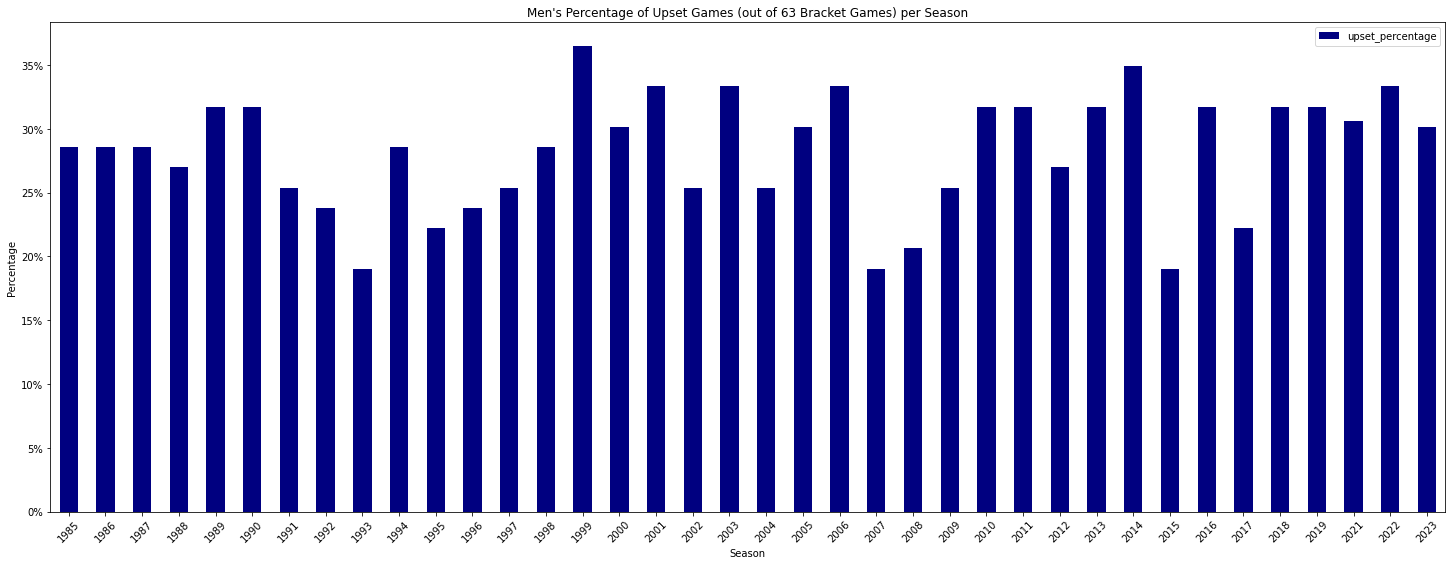

In [17]:
# plot men's percentage of upsets per season
mupset_percentage = (mupsets.groupby('Season').count() / df_mens.groupby('Season').count()).rename(columns={'score_diff': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
ax = mupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season',y='upset_percentage', title='Men\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='navy', rot=45)
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])
plt.show()

#### Round-by-Round Upsets in Men's Bracket

In [174]:
# create vars for each round
round1 = df_mens.loc[df_mens['round'] == 1]
round2 = df_mens.loc[df_mens['round'] == 2]
round3 = df_mens.loc[df_mens['round'] == 3]
round4 = df_mens.loc[df_mens['round'] == 4]
round5 = df_mens.loc[df_mens['round'] == 5]
round6 = df_mens.loc[df_mens['round'] == 6]

mr1upsets = mupsets[mupsets['round'] == 1]
mr2upsets = mupsets[mupsets['round'] == 2]
mr3upsets = mupsets[mupsets['round'] == 3]
mr4upsets = mupsets[mupsets['round'] == 4]
mr5upsets = mupsets[mupsets['round'] == 5]
mr6upsets = mupsets[mupsets['round'] == 6]

In [ ]:
for round in list(range(1,7)):
    print(f'Round {round} Upset %: {mupsets[mupsets["round"] == round].shape[0] / df_mens[df_mens["round"] == round].shape[0] * 100:.1f}%')

In [175]:
# all men's upset percentages each round
print('MEN\'S BRACKET:\n')
print(f'Round 1 Upset %: {mr1upsets.shape[0] / round1.shape[0] * 100: .1f}%, ({mr1upsets.shape[0]}/{round1.shape[0]}), avg seed diff: {mr1upsets["Wseed_diff"].mean(): .1f}')
print(f'Round 2 Upset %: {mr2upsets.shape[0] / round2.shape[0] * 100: .1f}%, ({mr2upsets.shape[0]}/{round2.shape[0]}), avg seed diff: {mr2upsets["Wseed_diff"].mean(): .1f}')
print(f'Round 3 Upset %: {mr3upsets.shape[0] / round3.shape[0] * 100: .1f}%, ({mr3upsets.shape[0]}/{round3.shape[0]}), avg seed diff: {mr3upsets["Wseed_diff"].mean(): .1f}')
print(f'Round 4 Upset %: {mr4upsets.shape[0] / round4.shape[0] * 100: .1f}%, ({mr4upsets.shape[0]}/{round4.shape[0]}), avg seed diff: {mr4upsets["Wseed_diff"].mean(): .1f}')
print(f'Round 5 Upset %: {mr5upsets.shape[0] / round5.shape[0] * 100: .1f}%, ({mr5upsets.shape[0]}/{round5.shape[0]}), avg seed diff: {mr5upsets["Wseed_diff"].mean(): .1f}')
print(f'Round 6 Upset %: {mr6upsets.shape[0] / round6.shape[0] * 100: .1f}%, ({mr6upsets.shape[0]}/{round6.shape[0]}), avg seed diff: {mr6upsets["Wseed_diff"].mean(): .1f}')

MEN'S BRACKET:

Round 1 Upset %:  25.9%, (315/1215), avg seed diff: -5.1
Round 2 Upset %:  29.3%, (178/608), avg seed diff: -5.1
Round 3 Upset %:  29.6%, (90/304), avg seed diff: -3.4
Round 4 Upset %:  44.1%, (67/152), avg seed diff: -2.7
Round 5 Upset %:  25.0%, (19/76), avg seed diff: -2.7
Round 6 Upset %:  18.4%, (7/38), avg seed diff: -2.7


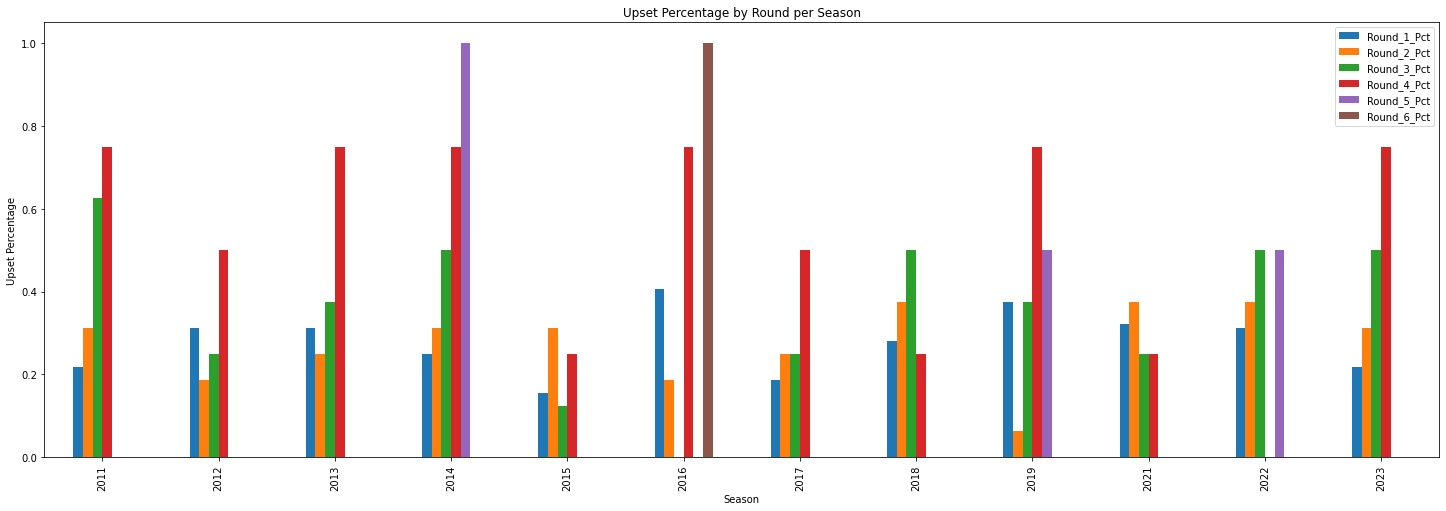

In [172]:
# list to hold data for plotting
plot_data = []

# calc percentages for each round and season
for i in range(1, 7):
    round_games = df_mens.loc[(df_mens['Season'] > 2010) & (df_mens['round'] == i)].groupby('Season')['round'].count()
    round_upsets = mupsets.loc[(mupsets['Season'] > 2010) & (mupsets['round'] == i)].groupby('Season')['round'].count()
    upset_percentage = (round_upsets / round_games).reset_index(name=f'Round_{i}_Pct')
    
    # merge into plot data, ensuring all seasons are represented
    if (i == 1):
        if plot_data:
            plot_data = pd.merge(plot_data, upset_percentage, on='Season', how='outer')
        else:
            plot_data = upset_percentage
    else:
        if not plot_data.empty:
            plot_data = pd.merge(plot_data, upset_percentage, on='Season', how='outer')
        else:
            plot_data = upset_percentage

# fill nulls
plot_data = plot_data.fillna(0)

# ensure Season is the first column and set it as index for plotting
plot_data = plot_data[['Season'] + [col for col in plot_data.columns if col != 'Season']]
plot_data.set_index('Season', inplace=True)

# plot
plot_data.plot(kind='bar', figsize=(25, 8))
plt.title('Upset Percentage by Round per Season')
plt.ylabel('Upset Percentage')
plt.xlabel('Season')
plt.show()

In [183]:
df_mens['Wseed_diff'].value_counts().sort_index()

Wseed_diff
-15      2
-13     11
-12      1
-11     22
-10      4
-9      36
-8      67
-7      75
-6       8
-5      90
-4      40
-3     118
-2      23
-1     179
 0      27
 1     217
 2      30
 3     199
 4      88
 5     174
 6      12
 7     172
 8     201
 9     143
 10      7
 11    150
 12      6
 13    141
 15    150
Name: count, dtype: int64

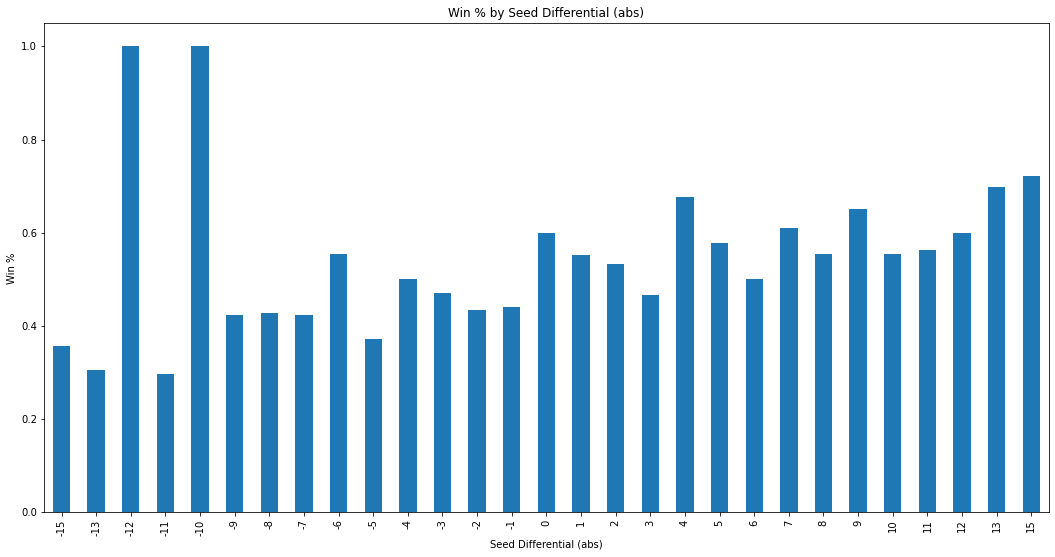

In [179]:
# calulcate seed diff with respect to team A
df_mens['Aseed_diff'] = df['B_Seed'] - df['A_Seed']

# look at win % by seed differential
df_mens.groupby(df_mens['Aseed_diff'])['win'].mean().plot(kind='bar', figsize=(18, 9), title='Win % by Seed Differential (abs)', xlabel='Seed Differential (abs)', ylabel='Win %');

In [182]:
df_mens.groupby(df_mens['Aseed_diff'])['win'].mean()

Aseed_diff
-15    0.357143
-13    0.306667
-12    1.000000
-11    0.296296
-10    1.000000
-9     0.423913
-8     0.428571
-7     0.423729
-6     0.555556
-5     0.373134
-4     0.500000
-3     0.471698
-2     0.434783
-1     0.440217
 0     0.600000
 1     0.552239
 2     0.533333
 3     0.466667
 4     0.676923
 5     0.577236
 6     0.500000
 7     0.609756
 8     0.553846
 9     0.650602
 10    0.555556
 11    0.563218
 12    0.600000
 13    0.698630
 15    0.721519
Name: win, dtype: float64

### Women's Upsets

In [81]:
# get favorite wins, get upsets, and equal seed wins
wfavorites = df_womens.loc[((df_womens['A_Seed'] < df_womens['B_Seed']) & (df_womens['win'] == 1)) | ((df_womens['A_Seed'] > df_womens['B_Seed']) & (df_womens['win'] == 0))] \
    [['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]
wupsets = df_womens.loc[((df_womens['A_Seed'] > df_womens['B_Seed']) & (df_womens['win'] == 1)) | ((df_womens['A_Seed'] < df_womens['B_Seed']) & (df_womens['win'] == 0))] \
    [['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]
wequals = df_womens.loc[df_womens['A_Seed'] == df_womens['B_Seed']][['Season', 'A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'score_diff']]

print('WOMEN\'S BRACKET:\n')
print(f'Percentage of games where better seed won: {wfavorites.shape[0] / df_womens.shape[0] * 100: .1f}%')
print(f'Percentage of games where worse seed won: {wupsets.shape[0] / df_womens.shape[0] * 100: .1f}%')
print(f'Percentage of games where seeds are equal: {wequals.shape[0] / df_womens.shape[0] * 100: .1f}%')

WOMEN'S BRACKET:

Percentage of games where better seed won:  76.2%
Percentage of games where worse seed won:  21.6%
Percentage of games where seeds are equal:  2.2%


It looks like results in the women's tournament are more 'chalked' (better seed wins 6% more often on average).

<ipython-input-82-5970389d0b9b>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


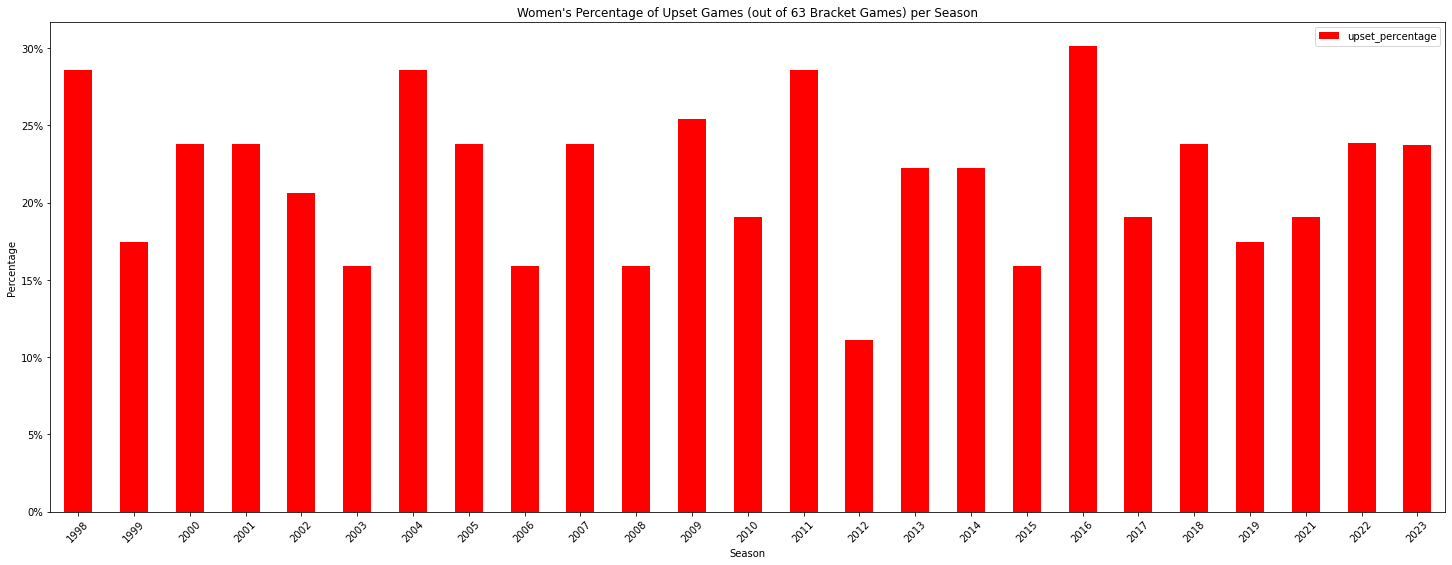

In [82]:
# plot women's percentage of upsets per season
wupset_percentage = (wupsets.groupby('Season').count() / df_womens.groupby('Season').count()).rename(columns={'score_diff': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']].dropna()
ax = wupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season', y='upset_percentage', title='Women\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='red', rot=45)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.show()

In [83]:
# men's
mupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,38.0,0.274143,0.045213,0.179104,0.25,0.285714,0.300817,0.365079


In [84]:
# women's
wupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,25.0,0.215869,0.048492,0.111111,0.174603,0.222222,0.238095,0.301587


On average, the men's bracket has a 6.5% higher upset rate.

#### Round-by-Round Upsets in Women's Bracket

In [ ]:
# create vars for each round
round1 = df_womens.loc[df_womens['round'] == 1]
round2 = df_womens.loc[df_womens['round'] == 2]
round3 = df_womens.loc[df_womens['round'] == 3]
round4 = df_womens.loc[df_womens['round'] == 4]
round5 = df_womens.loc[df_womens['round'] == 5]
round6 = df_womens.loc[df_womens['round'] == 6]

wr1upsets = wupsets[wupsets['round'] == 1]
wr2upsets = wupsets[wupsets['round'] == 2]
wr3upsets = wupsets[wupsets['round'] == 3]
wr4upsets = wupsets[wupsets['round'] == 4]
wr5upsets = wupsets[wupsets['round'] == 5]
wr6upsets = wupsets[wupsets['round'] == 6]

In [ ]:
# all men's upset percentages each round
print('WOMEN\'S BRACKET:\n')
print(f'Round 1 Upset Percentage: {wr1upsets.shape[0] / round1.shape[0] * 100: .1f}%')
print(f'Round 2 Upset Percentage: {wr2upsets.shape[0] / round2.shape[0] * 100: .1f}%')
print(f'Round 3 Upset Percentage: {wr3upsets.shape[0] / round3.shape[0] * 100: .1f}%')
print(f'Round 4 Upset Percentage: {wr4upsets.shape[0] / round4.shape[0] * 100: .1f}%')
print(f'Round 5 Upset Percentage: {wr5upsets.shape[0] / round5.shape[0] * 100: .1f}%')
print(f'Round 6 Upset Percentage: {wr6upsets.shape[0] / round6.shape[0] * 100: .1f}%')

## Additional Data

In [27]:
# load data
ordinals = pd.read_csv(mroot + 'MMasseyOrdinals.csv')
coaches = pd.read_csv(mroot + 'MTeamCoaches.csv')

rounds = pd.read_csv(mroot + 'MNCAATourneySeedRoundSlots.csv')
conf_games = pd.read_csv(mroot + 'MConferenceTourneyGames.csv')

Conference tourney games ARE contained in the regular season games table

In [ ]:
# combine df_mens and df_womens
df = pd.concat([df_mens, df_womens], ignore_index=True).reset_index(drop=True)

# save to csv
df.to_csv('data/processed/features_compact.csv', index=False)

In [ ]:
# load saved df
df = pd.read_csv('data/processed/features_compact.csv')